In [85]:
import time
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from pyope.ope import OPE, ValueRange
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os
from tqdm import tqdm


In [86]:
start_total_time = time.perf_counter()  # Start total execution time
# ✅ AES Encryption Setup
aes_key = os.urandom(32)  # Use this key for encryption/decryption

# ✅ AES Encrypt Function (Fast Mode - ECB)
def aes_encrypt_fast(data, key):
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_data = data.ljust(16)
    ciphertext = encryptor.update(padded_data.encode()) + encryptor.finalize()
    return ciphertext

# ✅ AES Decrypt Function (Fast Mode - ECB)
def aes_decrypt_fast(ciphertext, key):
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(ciphertext).decode().strip()

In [ ]:
# ✅ Load MNIST dataset
start_mnist_load_time = time.perf_counter()  # Start MNIST load time
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
#Splitting Dataset
X, y = mnist.data, mnist.target.astype(int)
end_mnist_load_time = time.perf_counter()  # End MNIST load time
mnist_load_time = end_mnist_load_time - start_mnist_load_time
print(f"MNIST Load Time: {mnist_load_time:.4f} seconds")


MNIST Load Time: 8.7310 seconds


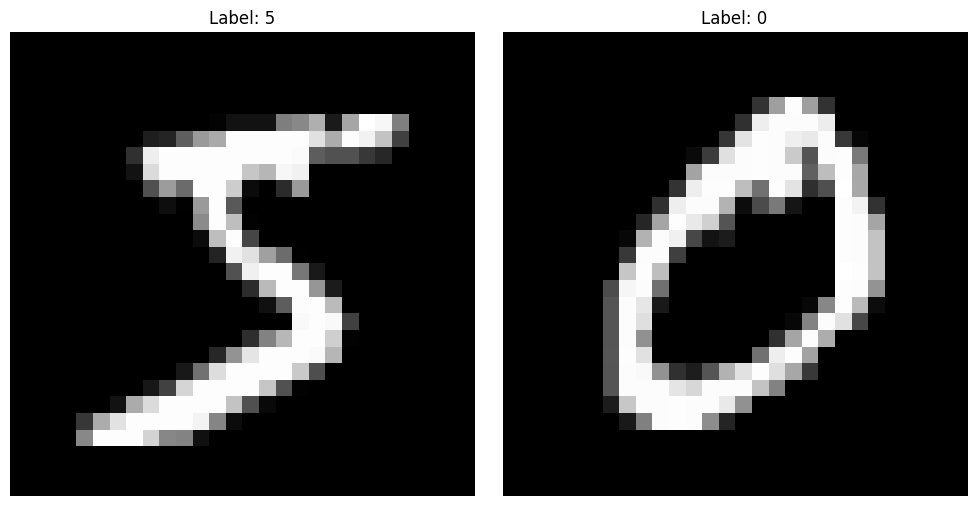

In [88]:
import matplotlib.pyplot as plt

# Plot the first two images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST images
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# ✅ Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Define OPE Encryption Scheme
ope_key = b'some_secure_key'
ope = OPE(ope_key, ValueRange(0, 255), ValueRange(0, 2**32))

def encrypt_dataset_with_ope(X):
    """Encrypt dataset using OPE for each feature with a progress bar."""
    return np.array([[ope.encrypt(int(val)) for val in sample] for sample in tqdm(X, desc="Encrypting")])

num_samples_training = len(X_train)
num_samples_testing = len(X_test)



X_test = X_test[:num_samples_testing]
#X_train = X_train[:num_samples_training]

# ✅ Encrypt Test Data Using OPE
start_ope_encryption_time = time.perf_counter()  # Start OPE encryption time
print("Encrypting Training Data...\n")
#X_train_encrypted = encrypt_dataset_with_ope(X_train)
print("Done encrypting Training Data!\n")
print("Encrypting Test Data...\n")
X_test_encrypted = encrypt_dataset_with_ope(X_test[:num_samples_testing])
print("Done encrypting Test Data!\n")


end_ope_encryption_time = time.perf_counter()  # End OPE encryption time
ope_encryption_time = end_ope_encryption_time - start_ope_encryption_time
print(f"OPE Encryption Time: {ope_encryption_time:.4f} seconds")

print("OPE Encryption Done!")
print("X_train shape:", X_train.shape)
print("X_test_encrypted shape:", X_test_encrypted.shape)


Encrypting Training Data...

Done encrypting Training Data!

Encrypting Test Data...



Encrypting: 100%|██████████| 3500/3500 [2:06:59<00:00,  2.18s/it]  


Done encrypting Test Data!

OPE Encryption Time: 7622.0819 seconds
OPE Encryption Done!
X_train shape: (66500, 784)
X_test_encrypted shape: (3500, 784)


In [ ]:
# ✅ Normalize and Clip pixel values (Ensure they are integers for OPE)
#Might benefit us if changed
scale_factor = 255  # Convert [0,1] range to [0,255]
X_train_scaled = np.clip((X_train * scale_factor), 0, 255).astype(int)
X_test_scaled = np.clip((X_test * scale_factor), 0, 255).astype(int)

In [91]:

num_estimators = 10

# ✅ Train RF Model on OPE-Encrypted Data
clf_ope = RandomForestClassifier(n_estimators=num_estimators, random_state=42)
#clf_ope.fit(X_train, y_train[:num_samples_training])  # Train on encrypted dataset
clf_ope.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [92]:
# ✅ Encrypt Labels using Faster AES-ECB
encrypted_labels = {label: aes_encrypt_fast(str(label), aes_key) for label in np.unique(y_train)}

In [93]:
# ✅ Extract & Encrypt Thresholds using OPE
thresholds = []
for tree in clf_ope.estimators_:
    tree_thresholds = tree.tree_.threshold
    valid_thresholds = tree_thresholds[tree_thresholds != -2]
    thresholds.extend(valid_thresholds)

thresholds = np.array(thresholds)
scale_factor = 1e6

In [94]:
# ✅ Compute min/max for scaled pixel values
scaled_pixels = np.clip(np.nan_to_num(X_train * scale_factor, nan=0, posinf=scale_factor, neginf=0).astype(int), -1e9, 1e9)
scaled_thresholds = np.clip(np.nan_to_num(thresholds * scale_factor, nan=0, posinf=scale_factor, neginf=0).astype(int), -1e9, 1e9)

min_value = int(min(scaled_pixels.min(), scaled_thresholds.min()) * 0.99)
max_value = int(max(scaled_pixels.max(), scaled_thresholds.max()) * 1.01)

In [95]:
# ✅ Define OPE Ranges
DEFAULT_OUT_RANGE_START, DEFAULT_OUT_RANGE_END = 0, 2**31 - 1
in_range = ValueRange(min_value, max_value)
out_range = ValueRange(DEFAULT_OUT_RANGE_START, DEFAULT_OUT_RANGE_END)

In [96]:
# ✅ Initialize OPE for thresholds and features
ope_key = OPE(b'some_secure_key', in_range, out_range)

In [97]:
# ✅ Encrypt Thresholds with OPE
start_threshold_encryption_time = time.perf_counter()  # Start threshold encryption time
total_thresholds = len(scaled_thresholds)
encrypted_thresholds = []

#Printing Progress Bar
for th in tqdm(scaled_thresholds, desc="Encrypting Thresholds"):
    encrypted_thresholds.append(ope_key.encrypt(int(th)))

encrypted_thresholds = np.array(encrypted_thresholds)
end_threshold_encryption_time = time.perf_counter()  # End threshold encryption time

Encrypting Thresholds: 100%|██████████| 54009/54009 [06:32<00:00, 137.65it/s]


In [98]:
# ✅ Encrypt Decision Tree Leaf Values using AES-ECB
encrypted_leaf_values = {
    node: aes_encrypt_fast(str(tree.tree_.value[node].argmax()), aes_key)
    for tree in clf_ope.estimators_
    for node in range(tree.tree_.node_count) if tree.tree_.feature[node] == -2
}

In [99]:
# ✅ Optimized Function to Encrypt an Image with OPE
def encrypt_image(image, ope_key, scale_factor=1e6):
    """Encrypt an image using OPE, ensuring valid integer input."""
    start_total = time.time()

    # ✅ Step 1: Scaling
    start_scaling = time.time()
    scaled_image = np.clip(np.nan_to_num(image * scale_factor, nan=0, posinf=scale_factor, neginf=0).astype(int), min_value, max_value)
    scaling_time = time.time() - start_scaling

    # ✅ Step 2: OPE Encryption
    start_encryption = time.time()
    encrypted_image = [ope_key.encrypt(int(pixel)) for pixel in scaled_image]
    encryption_time = time.time() - start_encryption

    total_time = time.time() - start_total

    return encrypted_image

In [100]:
# ✅ Optimized Function to Encrypt the Entire Dataset
def encrypt_dataset(X, ope_key, scale_factor=1e6):
    scaled_X = np.clip(np.nan_to_num(X * scale_factor, nan=0, posinf=scale_factor, neginf=0).astype(int), min_value, max_value)
    encrypted_X = []
    for idx, image in enumerate(scaled_X, start=1):
        start_time = time.time()
        encrypted_image = encrypt_image(image, ope_key)
        encryption_time = time.time() - start_time
        print(f"{idx}: Image Encryption Time: {encryption_time:.4f} sec")
        encrypted_X.append(encrypted_image)
    print(f"Number of encrypted images: {len(encrypted_X)}")  # Print the number of encrypted images
    return np.array(encrypted_X)

In [101]:
print(len(X_train))
print("X_test shape:", X_test.shape)


66500
X_test shape: (3500, 784)


In [ ]:
start_dataset_encryption_time = time.perf_counter()
print("Encrypting Test Dataset...")
X_test_encrypted = encrypt_dataset(X_test, ope_key)
end_dataset_encryption_time = time.perf_counter()  # Use the same function
dataset_encryption_time = end_dataset_encryption_time - start_dat.aset_encryption_time
print(f"Dataset Encryption Time: {dataset_encryption_time:.4f} seconds")

Encrypting Test Dataset...


C:\Users\Smash\AppData\Local\Temp\ipykernel_10836\1519317616.py:8: RuntimeWarning: invalid value encountered in cast
  scaled_image = np.clip(np.nan_to_num(image * scale_factor, nan=0, posinf=scale_factor, neginf=0).astype(int), min_value, max_value)


1: Image Encryption Time: 5.0739 sec
2: Image Encryption Time: 5.0821 sec
3: Image Encryption Time: 5.1122 sec
4: Image Encryption Time: 5.0853 sec
5: Image Encryption Time: 4.8065 sec
6: Image Encryption Time: 4.8126 sec
7: Image Encryption Time: 4.8268 sec
8: Image Encryption Time: 4.8291 sec
9: Image Encryption Time: 4.9222 sec
10: Image Encryption Time: 4.8106 sec
11: Image Encryption Time: 4.7939 sec
12: Image Encryption Time: 4.7699 sec
13: Image Encryption Time: 4.8102 sec
14: Image Encryption Time: 4.8348 sec
15: Image Encryption Time: 4.9719 sec
16: Image Encryption Time: 4.8164 sec
17: Image Encryption Time: 4.9292 sec
18: Image Encryption Time: 4.8155 sec
19: Image Encryption Time: 4.8487 sec
20: Image Encryption Time: 4.9387 sec
21: Image Encryption Time: 5.2019 sec
22: Image Encryption Time: 4.8296 sec
23: Image Encryption Time: 4.9168 sec
24: Image Encryption Time: 4.8528 sec
25: Image Encryption Time: 4.8975 sec
26: Image Encryption Time: 4.9416 sec
27: Image Encryption 

In [ ]:
# ✅ Function to Perform Secure Classification
def secure_classify(model, encrypted_X, encrypted_thresholds, encrypted_leaf_values, aes_key):
    votes = []
    for tree in model.estimators_:
        node = 0

        while tree.tree_.feature[node] != -2:
            feature_idx = tree.tree_.feature[node]
            encrypted_threshold = encrypted_thresholds[node]

            if encrypted_X[feature_idx] < encrypted_threshold:
                node = tree.tree_.children_left[node]
            else:
                node = tree.tree_.children_right[node]

        encrypted_value = encrypted_leaf_values[node]
        decrypted_value = aes_decrypt_fast(encrypted_value, aes_key)
        votes.append(int(decrypted_value))

    return Counter(votes).most_common(1)[0][0]

In [ ]:
# ✅ Function to Perform Secure Classification on All Test Images
def secure_classify_dataset(model, X_encrypted, encrypted_thresholds, encrypted_leaf_values, aes_key):
    return np.array([secure_classify(model, encrypted_X, encrypted_thresholds, encrypted_leaf_values, aes_key) for encrypted_X in X_encrypted])


In [ ]:
# ✅ Measure time taken for classification
start_time = time.time()
print("Performing Secure Classification...")
y_pred_encrypted = secure_classify_dataset(clf_ope, X_test_encrypted, encrypted_thresholds, encrypted_leaf_values, aes_key)
classification_time = time.time() - start_time
print(f"Secure Classification Time: {classification_time:.4f} seconds")


Performing Secure Classification...
Secure Classification Time: 0.0253 seconds


In [ ]:
# ✅ Compute Accuracy of Secure Inference
secure_accuracy = accuracy_score(y_test[:num_samples_testing], y_pred_encrypted)

# ✅ Print Secure Classification Results
print(f"Secure Random Forest Accuracy on Encrypted MNIST: {secure_accuracy:.4f}")

Secure Random Forest Accuracy on Encrypted MNIST: 0.3000


In [ ]:
# Measure time taken for classifying the first image
start_time = time.time()

print("Classifying the first image...")

# Encrypt the first image
first_image_encrypted = encrypt_image(X_test[0], ope_key)

# Perform secure classification
first_image_prediction = secure_classify(clf_ope, first_image_encrypted, encrypted_thresholds, encrypted_leaf_values, aes_key)

classification_time = time.time() - start_time
print(f"Prediction for the first image: {first_image_prediction}")
print(f"Actual label for the first image: {y_test[0]}")
print(f"Time taken for classification: {classification_time:.4f} seconds")

Classifying the first image...
Prediction for the first image: 8
Actual label for the first image: 8
Time taken for classification: 5.2657 seconds


In [ ]:

# Ensure all timer variables are defined to avoid NameError
if 'start_threshold_encryption_time' not in globals():
    start_threshold_encryption_time = end_threshold_encryption_time = time.perf_counter()

if 'start_label_encryption_time' not in globals():
    start_label_encryption_time = end_label_encryption_time = time.perf_counter()

if 'start_dataset_encryption_time' not in globals():
    start_dataset_encryption_time = end_dataset_encryption_time = time.perf_counter()

if 'start_rf_training_time' not in globals():
    start_rf_training_time = end_rf_training_time = time.perf_counter()

end_total_time = time.perf_counter()  # End total execution time

print("\n===== Execution Time Summary =====")
total_time = end_total_time - start_total_time
dataset_encryption_time = end_dataset_encryption_time - start_dataset_encryption_time
rf_training_time = end_rf_training_time - start_rf_training_time
threshold_encryption_time = end_threshold_encryption_time - start_threshold_encryption_time

total_percentage = 100
dataset_encryption_percentage = (dataset_encryption_time / total_time) * 100
rf_training_percentage = (rf_training_time / total_time) * 100
threshold_encryption_percentage = (threshold_encryption_time / total_time) * 100
classification_percentage = (classification_time / total_time) * 100
ope_encryption_percentage = (ope_encryption_time / total_time) * 100
mnist_load_percentage = (mnist_load_time / total_time) * 100

print(f"📌 Total Execution Time: {total_time:.4f} seconds")
print(f"📌 Dataset Encryption Time: {end_dataset_encryption_time - start_dataset_encryption_time:.4f} seconds ({dataset_encryption_percentage:.2f}%)")
print(f"📌 Random Forest Training Time: {end_rf_training_time - start_rf_training_time:.4f} seconds ({rf_training_percentage:.2f}%)")
print(f"📌 Threshold Encryption Time: {end_threshold_encryption_time - start_threshold_encryption_time:.4f} seconds ({threshold_encryption_percentage:.2f}%)")
print(f"📌 Secure Classification Time: {classification_time:.4f} seconds ({classification_percentage:.2f}%)")
print(f"📌 OPE Encryption Time: {ope_encryption_time:.4f} seconds ({ope_encryption_percentage:.2f}%)")
print(f"📌 MNIST Load Time: {mnist_load_time:.4f} seconds ({mnist_load_percentage:.2f}%)")
print(f"📌 Secure Random Forest Accuracy on Encrypted MNIST: {secure_accuracy:.4f}")
print(f"📌 Number of Decision Trees (num_estimators): {num_estimators}")
print(f"📌 Number of Images Used for Training: {len(X_train)}")
print(f"📌 Number of Images Used for Testing: {len(X_test)}")


===== Execution Time Summary =====
📌 Total Execution Time: 443.0702 seconds
📌 Dataset Encryption Time: 51.8391 seconds (11.70%)
📌 Random Forest Training Time: 0.0000 seconds (0.00%)
📌 Threshold Encryption Time: 339.2649 seconds (76.57%)
📌 Secure Classification Time: 5.2657 seconds (1.19%)
📌 OPE Encryption Time: 22.3432 seconds (5.04%)
📌 MNIST Load Time: 8.6834 seconds (1.96%)
📌 Secure Random Forest Accuracy on Encrypted MNIST: 0.3000
📌 Number of Decision Trees (num_estimators): 10
📌 Number of Images Used for Training: 56000
📌 Number of Images Used for Testing: 10


In [ ]:
print(f"Length of the dataset: {len(X)}")

Length of the dataset: 70000
